$$\large \color{green}{\textbf{The Value-At-Risk Measurements with Filtered Historical Simulation }}$$ 

$$\large \color{blue}{\textbf{Phuong Van Nguyen}}$$
$$\small \color{red}{\textbf{ phuong.nguyen@summer.barcelonagse.eu}}$$



This computer program was written by Phuong V. Nguyen, based on the $\textbf{Anacoda 1.9.7}$ and $\textbf{Python 3.7}$.

$$\text{1. Issue}$$

One of the most frequently used aspects of the volatility models is to measure the Value-At-Risk (VaR). This project attempts to use the GARCH model to measure the VaR.

$$\text{2. Methodology}$$

The GARCH model specification

$$\text{Mean equation:}$$
$$r_{t}=\mu + \epsilon_{t}$$

$$\text{Volatility equation:}$$
$$\sigma^{2}_{t}= \omega + \alpha \epsilon^{2}_{t} + \beta\sigma^{2}_{t-1}$$

$$\text{Volatility equation:}$$

$$\epsilon_{t}= \sigma_{t} e_{t}$$

$$e_{t} \sim N(0,1)$$

we use the model to estimate the VaR


Value-at-Risk (VaR) forecasts from GARCH models depend on the conditional mean, the conditional volatility and the quantile of the standardized residuals,

$$\text{VaR}_{t+1|t}=\mu_{t+1} -\sigma_{t+1|t}q_{\alpha} $$


where $q_{\alpha}$ is the $\alpha$ quantile of the standardized residuals, e.g., 5%. It is worth noting that there are a number of methods to calculate this qualtile, such as the parametric (or the variance–covariance approach), the Historical Simulation, and the Monte Carlo simulation. For example, my previous project used the Parametric method which under skewed and fat-tail distributions also provides promising results especially when the assumption that standardised returns are independent and identically distributed is set aside and when time variations are considered in conditional high-order moments. However, From a practical perspective, empirical literature shows that approaches based on the Extreme Value Theory and the Filtered Historical Simulation are the best methods for forecasting VaR.Thus, this project uses the Filtered Historical Simulation to calculate the VaR.


$$\text{3. Dataset}$$ 

One can download the dataset used to replicate my project at my Repositories on the Github site below

https://github.com/phuongvnguyen/The-VaR-Caculation-with-the-Filtered-Historical-Simulation


# Preparing Problem

##  Loading Libraries

In [1]:
import warnings
import itertools
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
#import pmdarima as pm
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from arch import arch_model
from arch.univariate import GARCH

## Defining some varibales for printing the result

In [2]:
Purple= '\033[95m'
Cyan= '\033[96m'
Darkcyan= '\033[36m'
Blue = '\033[94m'
Green = '\033[92m'
Yellow = '\033[93m'
Red = '\033[91m'
Bold = "\033[1m"
Reset = "\033[0;0m"
Underline= '\033[4m'
End = '\033[0m'

##  Loading Dataset

In [3]:
data = pd.read_excel("mydata.xlsx")


# Data Exploration and Preration

## Data exploration

In [4]:
data.head(5)

,DATE,CLOSE,TICKER,OPEN,HIGH,LOW,VOLUME
0,2007-09-19,125.0,VIC,125.0,125.0,125.0,307840
1,2007-09-20,131.0,VIC,131.0,131.0,130.0,794790
2,2007-09-21,137.0,VIC,137.0,137.0,135.0,1224660
3,2007-09-24,143.0,VIC,143.0,143.0,143.0,551130
4,2007-09-25,150.0,VIC,150.0,150.0,148.0,962110


## Computing returns
### Picking up the close prices

In [5]:
closePrice = data[['DATE','CLOSE']]
closePrice.head(5)

,DATE,CLOSE
0,2007-09-19,125.0
1,2007-09-20,131.0
2,2007-09-21,137.0
3,2007-09-24,143.0
4,2007-09-25,150.0


### Computing the daily returns

In [6]:
closePrice['Return'] = closePrice['CLOSE'].pct_change()
closePrice.head()

,DATE,CLOSE,Return
0,2007-09-19,125.0,NaN
1,2007-09-20,131.0,0.048000
2,2007-09-21,137.0,0.045802
3,2007-09-24,143.0,0.043796
4,2007-09-25,150.0,0.048951


In [7]:
daily_return=closePrice[['DATE','Return']]
daily_return.head()

,DATE,Return
0,2007-09-19,NaN
1,2007-09-20,0.048000
2,2007-09-21,0.045802
3,2007-09-24,0.043796
4,2007-09-25,0.048951


### Reseting index

In [8]:
daily_return =daily_return.set_index('DATE')
daily_return.head()

,Return
DATE,
2007-09-19,NaN
2007-09-20,0.048000
2007-09-21,0.045802
2007-09-24,0.043796
2007-09-25,0.048951


In [9]:
daily_return = 100 * daily_return.dropna()
daily_return.head()

,Return
DATE,
2007-09-20,4.800000
2007-09-21,4.580153
2007-09-24,4.379562
2007-09-25,4.895105
2007-09-26,4.666667


In [10]:
daily_return.index

DatetimeIndex(['2007-09-20', '2007-09-21', '2007-09-24', '2007-09-25',
               '2007-09-26', '2007-09-27', '2007-09-28', '2007-10-01',
               '2007-10-02', '2007-10-03',
               ...
               '2018-12-17', '2018-12-18', '2018-12-19', '2018-12-20',
               '2018-12-21', '2018-12-24', '2018-12-25', '2018-12-26',
               '2018-12-27', '2018-12-28'],
              dtype='datetime64[ns]', name='DATE', length=2813, freq=None)

### Plotting returns

Text(0.5, 0, 'Source: The Daily Close Price-based Calculations')

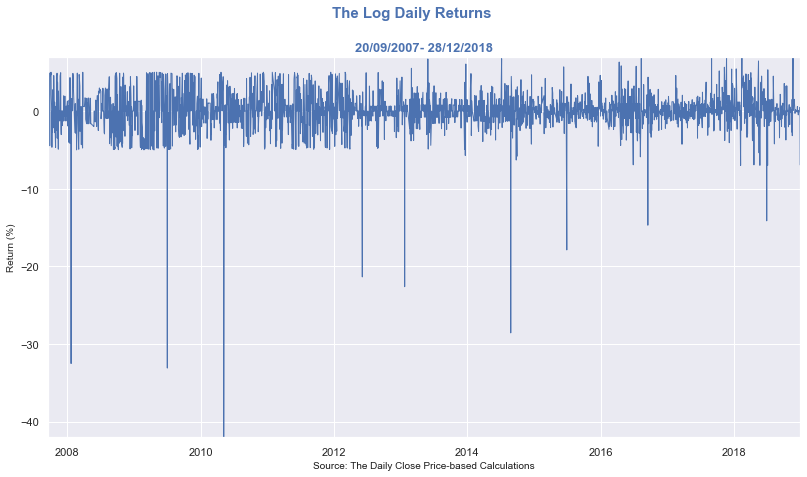

In [11]:
sns.set()
fig=plt.figure(figsize=(12,7))
plt.plot(daily_return.Return['2007':'2018'],LineWidth=1)
plt.autoscale(enable=True,axis='both',tight=True)
#plt.grid(linestyle=':',which='both',linewidth=2)
fig.suptitle('The Log Daily Returns', fontsize=15,fontweight='bold'
             ,color='b')
plt.title('20/09/2007- 28/12/2018',fontsize=13,fontweight='bold',
          color='b')
plt.ylabel('Return (%)',fontsize=10)
plt.xlabel('Source: The Daily Close Price-based Calculations',fontsize=10,fontweight='normal',color='k')

# Modelling GARCH model

$$\text{Mean equation:}$$
$$r_{t}=\mu + \epsilon_{t}$$

$$\text{Volatility equation:}$$
$$\sigma^{2}_{t}= \omega + \alpha \epsilon^{2}_{t} + \beta\sigma^{2}_{t-1}$$

$$\text{Volatility equation:}$$

$$\epsilon_{t}= \sigma_{t} e_{t}$$

$$e_{t} \sim N(0,1)$$


In [12]:
for row in daily_return.index: 
    print(row)

2007-09-20 00:00:00
2007-09-21 00:00:00
2007-09-24 00:00:00
2007-09-25 00:00:00
2007-09-26 00:00:00
2007-09-27 00:00:00
2007-09-28 00:00:00
2007-10-01 00:00:00
2007-10-02 00:00:00
2007-10-03 00:00:00
2007-10-04 00:00:00
2007-10-05 00:00:00
2007-10-08 00:00:00
2007-10-09 00:00:00
2007-10-10 00:00:00
2007-10-11 00:00:00
2007-10-12 00:00:00
2007-10-15 00:00:00
2007-10-16 00:00:00
2007-10-17 00:00:00
2007-10-18 00:00:00
2007-10-19 00:00:00
2007-10-22 00:00:00
2007-10-23 00:00:00
2007-10-24 00:00:00
2007-10-25 00:00:00
2007-10-26 00:00:00
2007-10-29 00:00:00
2007-10-30 00:00:00
2007-10-31 00:00:00
2007-11-01 00:00:00
2007-11-02 00:00:00
2007-11-05 00:00:00
2007-11-06 00:00:00
2007-11-07 00:00:00
2007-11-08 00:00:00
2007-11-09 00:00:00
2007-11-12 00:00:00
2007-11-13 00:00:00
2007-11-14 00:00:00
2007-11-15 00:00:00
2007-11-16 00:00:00
2007-11-19 00:00:00
2007-11-20 00:00:00
2007-11-21 00:00:00
2007-11-22 00:00:00
2007-11-23 00:00:00
2007-11-26 00:00:00
2007-11-27 00:00:00
2007-11-28 00:00:00


2012-02-23 00:00:00
2012-02-24 00:00:00
2012-02-27 00:00:00
2012-02-28 00:00:00
2012-02-29 00:00:00
2012-03-01 00:00:00
2012-03-02 00:00:00
2012-03-05 00:00:00
2012-03-06 00:00:00
2012-03-07 00:00:00
2012-03-08 00:00:00
2012-03-09 00:00:00
2012-03-12 00:00:00
2012-03-13 00:00:00
2012-03-14 00:00:00
2012-03-15 00:00:00
2012-03-16 00:00:00
2012-03-19 00:00:00
2012-03-20 00:00:00
2012-03-21 00:00:00
2012-03-22 00:00:00
2012-03-23 00:00:00
2012-03-26 00:00:00
2012-03-27 00:00:00
2012-03-28 00:00:00
2012-03-29 00:00:00
2012-03-30 00:00:00
2012-04-03 00:00:00
2012-04-04 00:00:00
2012-04-05 00:00:00
2012-04-06 00:00:00
2012-04-09 00:00:00
2012-04-10 00:00:00
2012-04-11 00:00:00
2012-04-12 00:00:00
2012-04-13 00:00:00
2012-04-16 00:00:00
2012-04-17 00:00:00
2012-04-18 00:00:00
2012-04-19 00:00:00
2012-04-20 00:00:00
2012-04-23 00:00:00
2012-04-24 00:00:00
2012-04-25 00:00:00
2012-04-26 00:00:00
2012-04-27 00:00:00
2012-05-02 00:00:00
2012-05-03 00:00:00
2012-05-04 00:00:00
2012-05-07 00:00:00


2016-07-28 00:00:00
2016-07-29 00:00:00
2016-08-01 00:00:00
2016-08-02 00:00:00
2016-08-03 00:00:00
2016-08-04 00:00:00
2016-08-05 00:00:00
2016-08-08 00:00:00
2016-08-09 00:00:00
2016-08-10 00:00:00
2016-08-11 00:00:00
2016-08-12 00:00:00
2016-08-15 00:00:00
2016-08-16 00:00:00
2016-08-17 00:00:00
2016-08-18 00:00:00
2016-08-19 00:00:00
2016-08-22 00:00:00
2016-08-23 00:00:00
2016-08-24 00:00:00
2016-08-25 00:00:00
2016-08-26 00:00:00
2016-08-29 00:00:00
2016-08-30 00:00:00
2016-08-31 00:00:00
2016-09-01 00:00:00
2016-09-05 00:00:00
2016-09-06 00:00:00
2016-09-07 00:00:00
2016-09-08 00:00:00
2016-09-09 00:00:00
2016-09-12 00:00:00
2016-09-13 00:00:00
2016-09-14 00:00:00
2016-09-15 00:00:00
2016-09-16 00:00:00
2016-09-19 00:00:00
2016-09-20 00:00:00
2016-09-21 00:00:00
2016-09-22 00:00:00
2016-09-23 00:00:00
2016-09-26 00:00:00
2016-09-27 00:00:00
2016-09-28 00:00:00
2016-09-29 00:00:00
2016-09-30 00:00:00
2016-10-03 00:00:00
2016-10-04 00:00:00
2016-10-05 00:00:00
2016-10-06 00:00:00


In [13]:
#garch = arch_model(daily_return,mean='AR',lags=5,
 #                  vol='GARCH',dist='studentst',
  #              p=1, o=0, q=1)
garch = arch_model(daily_return,vol='Garch', p=1, o=0, q=1, dist='skewt')
results_garch = garch.fit(last_obs='2017-12-29', update_freq=1,disp='on')
print(results_garch.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 5450.830660127428
Iteration:      2,   Func. Count:     18,   Neg. LLF: 5448.980117718381
Iteration:      3,   Func. Count:     27,   Neg. LLF: 5434.57238407916
Iteration:      4,   Func. Count:     36,   Neg. LLF: 5420.581651918099
Iteration:      5,   Func. Count:     46,   Neg. LLF: 5418.177595495172
Iteration:      6,   Func. Count:     55,   Neg. LLF: 5417.503822381816
Iteration:      7,   Func. Count:     63,   Neg. LLF: 5411.470438831067
Iteration:      8,   Func. Count:     72,   Neg. LLF: 5410.91415647983
Iteration:      9,   Func. Count:     81,   Neg. LLF: 5410.5971700711525
Iteration:     10,   Func. Count:     89,   Neg. LLF: 5410.553699533533
Iteration:     11,   Func. Count:     97,   Neg. LLF: 5410.532828617706
Iteration:     12,   Func. Count:    105,   Neg. LLF: 5410.532654828316
Iteration:     13,   Func. Count:    113,   Neg. LLF: 5410.532645739266
                           Constant Mean - GARCH Model Results   

# Estimating the VaR

we use the model to estimate the VaR


Value-at-Risk (VaR) forecasts from GARCH models depend on the conditional mean, the conditional volatility and the quantile of the standardized residuals,

$$\text{VaR}_{t+1|t}=\mu_{t+1} -\sigma_{t+1|t}q_{\alpha} $$


where $q_{\alpha}$ is the $\alpha$ quantile of the standardized residuals, e.g., 5%.

## Computing the quantiles

The quantiles, $q_{\alpha}$, can be computed using the Filtered Historical Simulation below.

### Computing the standardized residuals

It is worth noting that the standardized residuals computed by conditional volatility as follows.

In [18]:
std_garch = (daily_return.Return['2007':'2018'] - results_garch.params['mu']) / results_garch.conditional_volatility
std_garch = std_garch.dropna()
std_garch.head(5)



DATE
2007-09-20    1.251845
2007-09-21    1.052180
2007-09-24    0.969648
2007-09-25    1.084214
2007-09-26    0.983327
dtype: float64

### Computing the Quantiles

At the probabilities of 1% and 5%

In [20]:
FHS_quantiles_VaRgarch = std_garch.quantile([.01, .05])
print(Bold+'The quantiles at the probabilities of 1% and 5% are as follows'+End)
print(FHS_quantiles_VaRgarch)

The quantiles at the probabilities of 1% and 5% are as follows
0.01   -2.398340
0.05   -1.492076
dtype: float64


## Computing the conditional mean and volatilitie

In [23]:
FHS_forecasts_VaRgarch = results_garch.forecast(start='2018-01-03')
FHS_cond_mean_VaRgarch = FHS_forecasts_VaRgarch.mean['2018':]
FHS_cond_var_VaRgarch = FHS_forecasts_VaRgarch.variance['2018':]


## Computing the Value-At-Risk (VaR)

In [ ]:
FHS_value_at_risk = -FHS_cond_mean.values - np.sqrt(cond_var).values * q.values[None, :]
value_at_risk = pd.DataFrame(
    value_at_risk, columns=['1%', '5%'], index=cond_var.index)

In [26]:
FHS_value_at_risk = -FHS_cond_mean_VaRgarch.values - np.sqrt(FHS_cond_var_VaRgarch).values * FHS_quantiles_VaRgarch[None, :]

FHS_value_at_risk = pd.DataFrame(
    FHS_value_at_risk, columns=['1%', '5%'], index=FHS_cond_var_VaRgarch.index)

FHS_value_at_risk.head(5)

,1%,5%
DATE,,
2018-01-02,NaN,NaN
2018-01-03,5.668494,3.518980
2018-01-04,4.674815,2.900785
2018-01-05,4.383090,2.719294
2018-01-08,3.750736,2.325888


In [27]:
FHS_value_at_risk = FHS_value_at_risk.dropna()
FHS_value_at_risk.head(5)

,1%,5%
DATE,,
2018-01-03,5.668494,3.518980
2018-01-04,4.674815,2.900785
2018-01-05,4.383090,2.719294
2018-01-08,3.750736,2.325888
2018-01-09,3.347172,2.074819


# Visualizing the VaR vs actual values
## Picking actual data

In [28]:
rets_2018= daily_return['2018':].copy()
rets_2018.name = 'Return'
rets_2018.head(5)

,Return
DATE,
2018-01-02,1.164295
2018-01-03,2.941176
2018-01-04,0.621118
2018-01-05,-1.234568
2018-01-08,0.375000


## Plotting

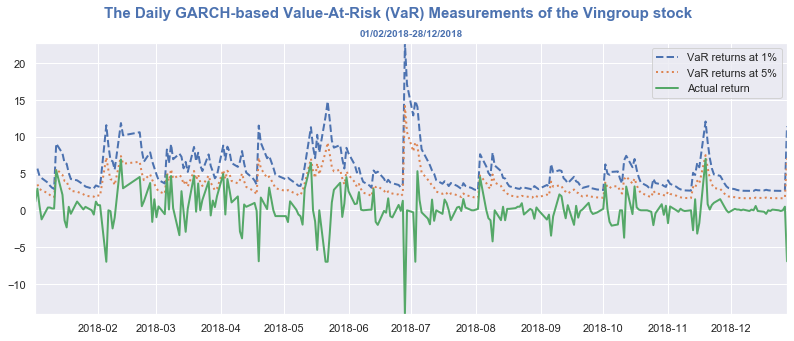

In [29]:
fig=plt.figure(figsize=(12,5))
plt.plot(FHS_value_at_risk['1%'] ,LineWidth=2,
         linestyle='--',label='VaR returns at 1%')
plt.plot(FHS_value_at_risk['5%'] ,LineWidth=2,
         linestyle=':',label='VaR returns at 5%')
plt.plot(rets_2018['Return'] ,LineWidth=2,
         linestyle='-',label='Actual return')
plt.suptitle('The Daily GARCH-based Value-At-Risk (VaR) Measurements of the Vingroup stock', 
             fontsize=15,fontweight='bold',
            color='b')
plt.title('01/02/2018-28/12/2018',fontsize=10,
          fontweight='bold',color='b')
plt.autoscale(enable=True,axis='both',tight=True)
plt.legend()